# Introduction

Author: Harneet Rishi

Purpose: Generate figures for promoter phenotypes in CRISPRi library

# Imports

## Modules/packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns

import random
import statsmodels.stats.multitest as smm
from scipy.special import comb
from scipy.stats import hypergeom, pearsonr, mannwhitneyu, sem

import warnings
warnings.filterwarnings('ignore')

## Functions

### Stats

In [2]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [3]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

### Mini Genome Browser Viz Functions

In [4]:
def get_promoter_info(gene_name):
    groSL_regulated_promoters = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains(gene_name))]
    groSL_regulated_promoters.set_index(keys = 'sgRNA seq', inplace = True, drop = False)
    dict_MapOrientStrand = {'for map': 'T', 'rev map': 'NT'}
    groSL_regulated_promoters['id'] = ''
    for sgRNA in groSL_regulated_promoters.index:
        mapping_orientation = groSL_regulated_promoters['mapping orientation'][sgRNA]
        promoter_name = groSL_regulated_promoters['(2) Promoter Name'][sgRNA]
        groSL_regulated_promoters['id'][sgRNA] = '%s (%s)' %(promoter_name, dict_MapOrientStrand[mapping_orientation])
    
    groSL_promoters_LRs = df_LRs_GEq_2e6_nmed_selcols.loc[groSL_regulated_promoters['sgRNA seq'].values]
    groSL_promoters_LRs['id'] = ''
    groSL_promoters_LRs['id'] = groSL_regulated_promoters['id']
    groSL_promoters_LRs_t0filt = groSL_promoters_LRs[(groSL_promoters_LRs['ET165_LB_ae_t0'] >= 5)]
    #sel_cols = ['LB_ae_avgLR_nmed', 'ET165_LB_ae_t0', 'FDR_LB', 'id']
    sel_cols = ['LB_ae_avgLR_nmed', 'ET165_LB_ae_t0', 'id', 'LB_FDR']
    groSL_promoters_LRs_t0filt_selcols = groSL_promoters_LRs_t0filt[sel_cols]
    for col in ['(2) Promoter Name', '(3) DNA strand where promoter is loc', '(4) Genome map position of TSS (+1)', 'mapping orientation' ,'id']:
        groSL_promoters_LRs_t0filt_selcols[col] = groSL_regulated_promoters[col]    
    
    return groSL_promoters_LRs_t0filt_selcols

In [5]:
def get_promoter_info_drop(gene_name, list_promoters_to_drop):
    groSL_regulated_promoters = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains(gene_name))]
    groSL_regulated_promoters = groSL_regulated_promoters[~groSL_regulated_promoters['(2) Promoter Name'].isin(list_promoters_to_drop) ]
    groSL_regulated_promoters.set_index(keys = 'sgRNA seq', inplace = True, drop = False)
    dict_MapOrientStrand = {'for map': 'T', 'rev map': 'NT'}
    groSL_regulated_promoters['id'] = ''
    for sgRNA in groSL_regulated_promoters.index:
        mapping_orientation = groSL_regulated_promoters['mapping orientation'][sgRNA]
        promoter_name = groSL_regulated_promoters['(2) Promoter Name'][sgRNA]
        groSL_regulated_promoters['id'][sgRNA] = '%s (%s)' %(promoter_name, dict_MapOrientStrand[mapping_orientation])
    
    groSL_promoters_LRs = df_LRs_GEq_2e6_nmed_selcols.loc[groSL_regulated_promoters['sgRNA seq'].values]
    groSL_promoters_LRs['id'] = ''
    groSL_promoters_LRs['id'] = groSL_regulated_promoters['id']
    groSL_promoters_LRs_t0filt = groSL_promoters_LRs[(groSL_promoters_LRs['ET165_LB_ae_t0'] >= 5)]
    sel_cols = ['LB_ae_avgLR_nmed', 'ET165_LB_ae_t0', 'id', 'LB_FDR']
    groSL_promoters_LRs_t0filt_selcols = groSL_promoters_LRs_t0filt[sel_cols]
    for col in ['(2) Promoter Name', '(3) DNA strand where promoter is loc', '(4) Genome map position of TSS (+1)', 'mapping orientation' ,'id']:
        groSL_promoters_LRs_t0filt_selcols[col] = groSL_regulated_promoters[col]    
    
    return groSL_promoters_LRs_t0filt_selcols

In [6]:
def plot_promoter_patch(df_promoter, ax, scale):
    TSS_pos_genome = df_promoter.iloc[0]['(4) Genome map position of TSS (+1)']
    promoter_strand_genome = df_promoter.iloc[0]['(3) DNA strand where promoter is loc']
    if promoter_strand_genome == 'forward':
        p1 = [TSS_pos_genome - 60, 0]
        p2 = [TSS_pos_genome - 60, 3]
        p3 = [TSS_pos_genome, 3]
        arrow = '>'
    else:
        p1 = [TSS_pos_genome + 60, 0]
        p2 = [TSS_pos_genome + 60, -3]
        p3 = [TSS_pos_genome, -3]
        arrow = '<'
    
    verts = [p1, p2, p3]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=2, edgecolor  = 'gray')
    ax.add_patch(patch)
    ax.plot(verts[-1][0], verts[-1][1], arrow, lw=2, color = 'gray', markeredgecolor = 'gray', ms = scale)
    return

In [7]:
def plot_gene_patch(df, ax, color):
    strand = df['(6) DNA strand where gene is coded'].values
    xmin = df['(4) Gene_pos_left'].values
    xmax = df['(5) Gene_pos_right'].values
    
    if strand == 'forward':
        strand_factor = 1
    else:
        strand_factor = -1
        
    p1 = [xmin, 0]
    p2 = [xmin, 2*strand_factor]
    p3 = [xmax, 2*strand_factor]
    p4 = [xmax, 0]
    
    verts = [p1, p2, p3, p4, (0,0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor = color, lw = 1, edgecolor = 'gray')
    ax.add_patch(patch)
    
    return

In [8]:
def plot_gene_patch_2(df, ax, color):
    strand = df['(6) DNA strand where gene is coded'].values
    xmin = df['(4) Gene_pos_left'].values
    xmax = df['(5) Gene_pos_right'].values
    
    if strand == 'forward':
        strand_factor = 1
        p1 = [xmin, 0]
        p2 = [xmin, 2*strand_factor]
        p3 = [xmax - 25, 2*strand_factor]
        p4 = [xmax, strand_factor]
        p5 = [xmax - 25, 0]
    else:
        strand_factor = -1
        p1 = [xmin + 25, 0]
        p2 = [xmax, 0]
        p3 = [xmax, 2*strand_factor]
        p4 = [xmin + 25, 2*strand_factor]
        p5 = [xmin, strand_factor]
            
    verts = [p1, p2, p3, p4, p5, (0,0)]
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor = color, lw = 1, edgecolor = 'gray')
    ax.add_patch(patch)
    
    return

## Data

### sgRNA annotations

In [9]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head(10)

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0
cgtactgctcgggcccgaaa,cgtactgctcgggcccgaaa,2751592,+,Promoter,,NaN,NaN,0
ggaaaagttttgcgctatgt,ggaaaagttttgcgctatgt,2554,+,Promoter,,NaN,NaN,0
tagtccttccccttacggga,tagtccttccccttacggga,137014,-,Promoter,,NaN,NaN,0
tggttttatatacagtaaag,tggttttatatacagtaaag,2749746,-,Promoter,,NaN,NaN,0


In [10]:
list_genes_ess = list(set(df_sgRNA_info_update_3[df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)'] == 1]['gene_name_F2'].values))

In [11]:
df_M9Essential_Joyce = pd.read_table('Annotations//ConditionallyEssentialGenes_M91%glycerol_aerobic_T37C_JoyceJBac2006.txt', sep = '\t')
df_M9Essential_Joyce.set_index(keys = 'Accession-1', inplace = True, drop = False)
df_M9Essential_Joyce.head()

,All-Genes,Accession-1,Accession-2,Common-Name
Accession-1,,,,
b2818,argA,b2818,ECK2814,argA
b3957,argE,b3957,ECK3948,argE
b3960,argH,b3960,ECK3951,argH
b0908,aroA,b0908,ECK0899,aroA
b3389,aroB,b3389,ECK3376,aroB


In [12]:
M9_ess = 'argA , argE , argH , aroA , aroB , aroC , aroE , atpA , atpB , atpC , atpF , atpG , atpH , carA , carB , cra , crr , cysA , cysB , cysC , cysD , cysE , cysH , cysI , cysJ , cysK , cysN , cysP , cysQ , cysU , fes , folB , glnA , glpD , glpK , gltA , glyA , guaA , guaB , hisA , hisB , hisC , hisD , hisF , hisG , hisH , hisI , icd , ilvA , ilvB , ilvC , ilvD , iscS , leuA , leuB , leuC , leuD , leuL , lysA , metA , metB , metC , metF , metL , metR , nadA , nadB , nadC , pabA , pabB , panB , panC , panD , panZ , pdxA , pdxB , pdxH , pdxJ , pheA , ppc , proA , proB , proC , ptsI , purA , purC , purD , purE , purF , purH , purK , purL , purM , pyrB , pyrC , pyrD , pyrE , pyrF , serA , serB , serC , thrA , thrB , thrC , thyA , trpA , trpB , trpC , trpD , trpE , tyrA , ubiG , ubiH'.split(',')
M9_ess = [g.replace(' ', '') for g in M9_ess]

In [13]:
df_sgRNA_info_Promoter = df_sgRNA_info_update_3[df_sgRNA_info_update_3['category'] == 'Promoter']
df_sgRNA_info_Promoter = df_sgRNA_info_Promoter[[u'seq', u'pos', u'strand', u'category']]

### RegulonDB Annotations

#### RegulonDB 2015

In [14]:
colnames = ['(1) RegulonDB Promoter ID',
           '(2) Promoter Name',
           '(3) DNA strand where promoter is loc',
           '(4) Genome map position of TSS (+1)',
           '(5) Sigma Factor of Promoter',
           '(6) Promoter Seq (+1 upp case)',
           '(7) Evidence for promoter exist',
           '(8) Evidence confidence (Confirmed, Strong, Weak)']
PromoterSet_2015 = pd.read_csv('Annotations/PromoterSet.csv', skiprows= 36, names = colnames)
PromoterSet_2015.set_index(keys = '(1) RegulonDB Promoter ID', inplace = True, drop = False)
PromoterSet_2015.head(2)

,(1) RegulonDB Promoter ID,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB Promoter ID,,,,,,,,
ECK125153332,ECK125153332,TSS_103,reverse,62712,unknown,tgttggtcgccgccacgcgccgcgcgtcctgctggctgacgaagtg...,[RS-EPT-CBR|S|RNA-seq using two enrichment str...,NaN
ECK125154259,ECK125154259,TSS_1030,reverse,952456,unknown,tggctacatcaacaagcagcttgagaaaatcgttggtctgcagact...,[RS-EPT-CBR|S|RNA-seq using two enrichment str...,NaN


#### RegulonDB 2018

In [15]:
colnames = ['(1) RegulonDB Promoter ID',
           '(2) Promoter Name',
           '(3) DNA strand where promoter is loc',
           '(4) Genome map position of TSS (+1)',
           '(5) Sigma Factor of Promoter',
           '(6) Promoter Seq (+1 upp case)',
           '(7) Evidence for promoter exist',
           '(8) Evidence confidence (Confirmed, Strong, Weak)']
PromoterSet = pd.read_csv('Annotations/RegulonDBAnnotations_052018/PromoterSet.csv', skiprows= 36, names = colnames)
PromoterSet.set_index(keys = '(1) RegulonDB Promoter ID', inplace = True, drop = False)
PromoterSet.head(1)

,(1) RegulonDB Promoter ID,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB Promoter ID,,,,,,,,
ECK125230824,ECK125230824,TSS_1,forward,38,unknown,aaacgccttagtaagtatttttcagcttttcattctgactgcaacg...,[RS-EPT-CBR|S|RNA-seq using two enrichment str...,Strong


In [16]:
colnames = ['(1) RegulonDB Gene ID',
           '(2) Gene name', '(3) bnumber', '(4) Gene_pos_left', '(5) Gene_pos_right',
           '(6) DNA strand where gene is coded', '(7) Product name', '(8) Evidence for gene exist',
           '(9) PMIDs list', '(10) Evidence confidence (Confirmed, Strong, Weak)']

GeneSet = pd.read_table('Annotations/RegulonDBAnnotations_052018/GeneProductSet.txt', skiprows = 38, names = colnames)
GeneSet.set_index(keys = '(1) RegulonDB Gene ID', inplace = True, drop = False)
GeneSet.head(1)

,(1) RegulonDB Gene ID,(2) Gene name,(3) bnumber,(4) Gene_pos_left,(5) Gene_pos_right,(6) DNA strand where gene is coded,(7) Product name,(8) Evidence for gene exist,(9) PMIDs list,"(10) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB Gene ID,,,,,,,,,,
ECK120001251,ECK120001251,thrL,b0001,190.0,255.0,forward,thr operon leader peptide,"[IDA|S|Inferred from direct assay],[IMP|W|Infe...","3112412,318654,6811557,",Strong


In [17]:
#2017 annotations
colnames = ['(1) RegulonDB TU ID',
            '(2) TU name',
            '(3) Operon name containing TU',
            '(4) Name of the gene(s) in TU',
            '(5) Promoter Name',
            '(6) Evidence for TU exist',
            '(7) Evidence confidence (Confirmed, Strong, Weak)']

TUSet = pd.read_table('Annotations/RegulonDBAnnotations_052018/TUSet.txt', sep = '\t',skiprows= 35, names = colnames)
TUSet.set_index(keys = '(1) RegulonDB TU ID', inplace = True, drop = False)
TUSet.head(3)

,(1) RegulonDB TU ID,(2) TU name,(3) Operon name containing TU,(4) Name of the gene(s) in TU,(5) Promoter Name,(6) Evidence for TU exist,"(7) Evidence confidence (Confirmed, Strong, Weak)"
(1) RegulonDB TU ID,,,,,,,
ECK120026560,ECK120026560,C0067,C0067,C0067,NaN,[ICWHO|W|Inferred computationally without huma...,Weak
ECK120030224,ECK120030224,C0299,C0299,C0299,NaN,NaN,NaN
ECK120030164,ECK120030164,C0362,C0362,C0362,NaN,[IHBCE|W|Inferred by a human based on computat...,Weak


### Significance Values

In [18]:
df_topd24t0_LB = pd.read_csv('SourceData/edgeR_3-topd24t0_LB_ae.csv')
df_topd24t0_LB.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_M9 = pd.read_csv('SourceData/edgeR_4-topd24t0_M9_ae.csv')
df_topd24t0_M9.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_M9Ca = pd.read_csv('SourceData/edgeR_4-topd24t0_M9Ca_ae.csv')
df_topd24t0_M9Ca.set_index(keys = 'seq', inplace = True, drop = False)

df_topd24t0_LB_an = pd.read_csv('SourceData/edgeR_5-topd24t0_LB_anaerobic.csv')
df_topd24t0_LB_an.set_index(keys = 'seq', inplace = True, drop = False)

### Fitness values

#### Aerobic

In [19]:
df_LRs_GEq_2e6 = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6.csv')
df_LRs_GEq_2e6_nmed = pd.read_csv('SourceData/APAHR007_v4_20-df_LRs_GEq_2e6_nmed.csv')
df_LRs_GEq_2e6_nmed.set_index(keys = 'seq', inplace = True, drop = False)

cols_LB = [u'd24_tR2_LR_nmed', u'd24_tR3_LR_nmed', u'ET165_LB_ae_d24_B5T2_LR_nmed', u'ET165_LB_ae_d24_B6T2_LR_nmed',
           u'ET165_R1_1.25mL_d24_LR_nmed', u'ET165_R2_1.25mL_d24_LR_nmed', u'ET165_R3.1_1mL_d24_LR_nmed',
           u'ET165_R3.2_1mL_d24_LR_nmed', u'ET165_R4_2mL_d24_LR_nmed']
cols_M9Ca = [ u'M9_B2T1_d24_Ca_LR_nmed', u'M9_B2T2_d24_Ca_LR_nmed', u'M9_B2T3_d24_Ca_LR_nmed']
cols_M9 = [u'M9_B2T1_d24_LR_nmed', u'M9_B2T2_d24_LR_nmed', u'M9_B2T3_d24_LR_nmed']

df_LRs_GEq_2e6_nmed['LB_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_LB].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9Ca_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9Ca].mean(axis = 1)
df_LRs_GEq_2e6_nmed['M9_ae_avgLR_nmed'] = df_LRs_GEq_2e6_nmed[cols_M9].mean(axis = 1)

cols_to_transfer = [u'strand', u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
for col in cols_to_transfer:
    df_LRs_GEq_2e6_nmed[col] = df_sgRNA_info_update_3[col]
    
sel_cols = ['seq','LB_ae_avgLR_nmed', 'M9Ca_ae_avgLR_nmed', 'M9_ae_avgLR_nmed',
            u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly',
            u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', 
                    u'Class(1:essential 2:noessential 3:unknown)']
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed[sel_cols]

#### Anaerobic

In [20]:
df_LRs_GEq_2e6_nmed_an = pd.read_csv('SourceData/Anaerobic_01-df_sgRNA_counts_LRnmed_withinfo.csv')
df_LRs_GEq_2e6_nmed_an.set_index(keys = 'seq', inplace = True, drop = False)
df_LRs_GEq_2e6_nmed_an.drop(labels = 'seq.1', axis = 1, inplace = True)
cols_LB_an = [c for c in df_LRs_GEq_2e6_nmed_an.columns if 'LR_nmed' in c]
df_LRs_GEq_2e6_nmed_an['LB_an_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_an[cols_LB_an].mean(axis = 1)

In [21]:
cols_drop = [c for c in df_LRs_GEq_2e6_nmed_an.columns if (('O2' in c) and not(('nmed' in c) or ('t0' in c)) )]
cols_drop

df_LRs_GEq_2e6_nmed_an_selcols = df_LRs_GEq_2e6_nmed_an[[c for c in df_LRs_GEq_2e6_nmed_an.columns if not(c in cols_drop)]]
df_LRs_GEq_2e6_nmed_an_selcols.drop(labels = ['O2_d24_1_LR_nmed', 'O2_d24_2_LR_nmed', 'O2_d24_3_LR_nmed'], axis = 1, inplace = True)
df_LRs_GEq_2e6_nmed_an_selcols['O2_t0_med'] = df_LRs_GEq_2e6_nmed_an_selcols[[c for c in df_LRs_GEq_2e6_nmed_an_selcols.columns if 'O2_t0' in c]].median(axis = 1)
df_LRs_GEq_2e6_nmed_an_selcols['LB_an_logFC'] = df_topd24t0_LB_an['logFC']
df_LRs_GEq_2e6_nmed_an_selcols['LB_an_FDR'] = df_topd24t0_LB_an['FDR']
df_LRs_GEq_2e6_nmed_an_selcols

,seq,O2_t0_1,O2_t0_2,O2_t0_3,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown),LB_an_avgLR_nmed,O2_t0_med,LB_an_logFC,LB_an_FDR
seq,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,163.0,104.0,100.0,191,-,All_Genes,thr operon leader peptide,thrL,b0001,2,-0.217976,104.0,-0.242925,4.004926e-01
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,167.0,120.0,97.0,837587,+,All_Genes,conserved protein,ybiI,b0803,2,0.007942,120.0,-0.024016,9.991193e-01
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,161.0,95.0,80.0,858246,+,All_Genes,predicted protein,ybiU,b0821,2,-0.401922,95.0,-0.428397,7.547124e-02
tcttgactggctaatgcacg,tcttgactggctaatgcacg,180.0,97.0,86.0,1089003,+,All_Genes,poly-&beta;-16-N-acetyl-D-glucosamine N-deacet...,pgaB,b1023,2,0.146219,97.0,0.108063,8.260996e-01
ccgaactccctgattccttt,ccgaactccctgattccttt,102.0,69.0,67.0,3182919,-,All_Genes,conserved protein,yqiC,b3042,2,0.145074,69.0,0.112062,8.575393e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tgagttgatttaccgccggt,tgagttgatttaccgccggt,147.0,113.0,92.0,3182691,+,All_Genes,SroG,sroG,NaN,3,0.266227,113.0,0.237756,4.412028e-01
gagttgatttaccgccggtg,gagttgatttaccgccggtg,142.0,106.0,94.0,3182692,+,All_Genes,SroG,sroG,NaN,3,0.402920,106.0,0.379877,8.661559e-02
cgccccgccctgagaataag,cgccccgccctgagaataag,251.0,163.0,162.0,3182720,+,All_Genes,SroG,sroG,NaN,3,-1.855540,163.0,-1.791129,9.749726e-19


#### Merge aerobic / anaerobic

In [22]:
df_LRs_GEq_2e6_nmed_selcols['LB_an_avgLR_nmed'] = df_LRs_GEq_2e6_nmed_an['LB_an_avgLR_nmed']
df_LRs_GEq_2e6_nmed_selcols['LB_an_logFC'] = df_LRs_GEq_2e6_nmed_an_selcols['LB_an_logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_an_FDR'] = df_LRs_GEq_2e6_nmed_an_selcols['LB_an_FDR']
df_LRs_GEq_2e6_nmed_selcols['ET165_LB_an_t0'] = df_LRs_GEq_2e6_nmed_an_selcols['O2_t0_med']

In [23]:
df_LRs_GEq_2e6_nmed_selcols['LB_logFC'] = df_topd24t0_LB['logFC']
df_LRs_GEq_2e6_nmed_selcols['LB_FDR'] = df_topd24t0_LB['FDR']
df_LRs_GEq_2e6_nmed_selcols['M9_logFC'] = df_topd24t0_M9['logFC']
df_LRs_GEq_2e6_nmed_selcols['M9_FDR'] = df_topd24t0_M9['FDR']
df_LRs_GEq_2e6_nmed_selcols['M9Ca_logFC'] = df_topd24t0_M9Ca['logFC']
df_LRs_GEq_2e6_nmed_selcols['M9Ca_FDR'] = df_topd24t0_M9Ca['FDR']

In [24]:
df_LRs_GEq_2e6_nmed_selcols = df_LRs_GEq_2e6_nmed_selcols[[u'LB_ae_avgLR_nmed', u'M9Ca_ae_avgLR_nmed', u'M9_ae_avgLR_nmed', u'LB_an_avgLR_nmed',
                                                          u'ET165_LB_ae_t0', u'M9_t0_BR2_glu+gly', u'ET165_LB_an_t0',
                                                          u'category', u'product_name', u'gene_name_F2', u'bnumber_F2', u'Class(1:essential 2:noessential 3:unknown)',
                                                          u'LB_logFC', u'LB_FDR', u'M9Ca_logFC', u'M9Ca_FDR', u'M9_logFC', u'M9_FDR', u'LB_an_logFC', u'LB_an_FDR',
                                                          u'seq']]

### Promoter-gene/TU-sgRNA mappings

In [25]:
df_map_ann_more = pd.read_csv('SourceData/APAHR007_v4_26-df_map_ann_more.csv')
df_map_ann_more.drop(labels = 'Unnamed: 0', inplace = True, axis = 1)
df_map_ann_more.head(1)

,sgRNA seq,promoter ECK#,mapping orientation,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)",LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,sgRNA_midpos_genome,rel_pos_sgRNA_Plus1,PAM present
0,gcttttcattctgactgcaa,ECK125230824,for map,TSS_1,forward,38,unknown,aaacgccttagtaagtatttttcagcttttcattctgactgcaacg...,[RS-EPT-CBR|S|RNA-seq using two enrichment str...,Strong,-0.175016,0.689267,0.020912,8.0,2.0,12.0,-26.0,y


In [26]:
#note: don't use rel_pos_sgRNA_Plus1 column. it wasn't properly indexed
df_map_ann_PromInTUSet_dropnapromotername = pd.read_csv('SourceData/APAHR007_v4_27-df_map_ann_PromInTUSet_dropnapromotername.csv')
df_map_ann_PromInTUSet_dropnapromotername.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
df_map_ann_PromInTUSet_dropnapromotername.head(2)

,sgRNA seq,promoter ECK#,mapping orientation,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)",LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,(2) TU name,(3) Operon name containing TU,(4) Name of the gene(s) in TU,(5) Promoter Name,(6) Evidence for TU exist,"(7) Evidence confidence (Confirmed, Strong, Weak)",#EssGene_TU_LB,#EssGene_TU_M9,sgRNA_midpos_genome,rel_pos_sgRNA_Plus1,FDR_LB,FDR_M9Ca,FDR_M9
0,acagcaatgttgctctcgcc,ECK125135055,for map,aaeXp,reverse,3389430,NaN,tcacataatatagataacagcataacagttacgctaatatattaaa...,[HTTIM|S|High-throughput transcription initiat...,Strong,-0.313167,0.331462,0.620627,82.0,38.0,['aaeXAB'],['aaeXAB'],"['aaeX,aaeA,aaeB']",['aaeXp'],['[ICWHO|W|Inferred computationally without hu...,['Weak'],0,0,12.0,-26.0,0.989054,0.705956,0.271200
1,cgggcttgctatctcgctga,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-2.240971,-3.774839,-2.753064,19.0,11.0,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0,31.0,-7.0,0.000002,0.000016,0.001074


In [27]:
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB = pd.read_csv('SourceData/APAHR007_v4_27-df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB.csv', index_col = 0)
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB.head(1)

,sgRNA seq,promoter ECK#,mapping orientation,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)",LB_ae_avgLR_nmed,M9Ca_ae_avgLR_nmed,M9_ae_avgLR_nmed,ET165_LB_ae_t0,M9_t0_BR2_glu+gly,(2) TU name,(3) Operon name containing TU,(4) Name of the gene(s) in TU,(5) Promoter Name,(6) Evidence for TU exist,"(7) Evidence confidence (Confirmed, Strong, Weak)",#EssGene_TU_LB,#EssGene_TU_M9,sgRNA_midpos_genome,rel_pos_sgRNA_Plus1,FDR_LB,FDR_M9Ca,FDR_M9
1,cgggcttgctatctcgctga,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-2.240971,-3.774839,-2.753064,19.0,11.0,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0,31.0,-7.0,0.000002,0.000016,0.001074


### Essential TUs (LB and M9)

In [28]:
df_map_ann_PromInTUSet_dropnapromotername_LBM9Ess = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['#EssGene_TU_LB'] > 0) |
                                          (df_map_ann_PromInTUSet_dropnapromotername['#EssGene_TU_M9'] > 0)]

### Essential TUs (LB)

In [29]:
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_ForPaper_CatSep = pd.read_csv('SourceData/APAHR007_v4_27-df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_ForPaper_CategoriesSeparated.csv')
cols_to_drop = [c for c in df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_ForPaper_CatSep.columns if 'Unnamed' in c]
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_ForPaper_CatSep.drop(labels = cols_to_drop, axis = 1, inplace = True)
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_ForPaper_CatSep.head(2)

,sgRNA seq,promoter ECK#,mapping orientation,(2) Promoter Name,(3) DNA strand where promoter is loc,(4) Genome map position of TSS (+1),(5) Sigma Factor of Promoter,(6) Promoter Seq (+1 upp case),(7) Evidence for promoter exist,"(8) Evidence confidence (Confirmed, Strong, Weak)",LB_ae_avgLR_nmed,ET165_LB_ae_t0,(2) TU name,(3) Operon name containing TU,(4) Name of the gene(s) in TU,(5) Promoter Name,(6) Evidence for TU exist,"(7) Evidence confidence (Confirmed, Strong, Weak)",#EssGene_TU_LB,FDR_LB,Confidence (n),Category (n),Additional Notes,dict_annotations,agree annotation,confirm theoretical promoter,tandem promoter,readthrough,other
0,cgggcttgctatctcgctga,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-2.240971,19,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0.000002,high; low; low,tandem promoter; readthrough; agree annotation,upstream gene ~13 bp away,"{'readthrough': 'low', 'tandem promoter': 'hig...",low,0,high,low,0.0
1,ttgctatctcgctgacggac,ECK120010467,for map,accAp,forward,208411,Sigma70,gcccgggaaaaatatgctcgcgggcttgctatctcgctgacggaca...,[TIM|S|Transcription initiation mapping],Strong,-0.386808,43,['accA'],['accA'],['accA'],['accAp'],['[LTED|S|Length of transcript experimentally ...,['Strong'],1,0.570616,high; low; low,tandem promoter; readthrough; agree annotation,upstream gene ~13 bp away,"{'readthrough': 'low', 'tandem promoter': 'hig...",low,0,high,low,0.0


# Figures

## Figure 5a

### Annotation info

### Visualization

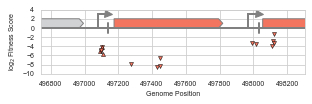

In [30]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene1 = 'htpG'
gene2 = 'adk'
gene3 = 'hemH'

list_genes = [gene1, gene2, gene3]

annotation_offset = 776

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

colors = ['#D1D2D4', '#F37560', '#F37560']

leg_patches = []
i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    leg_patches.append(patches.Patch(color = colors[i], label = gene))
    plt.ylim([-10,4])
    i+=1
plt.legend(handles = leg_patches, loc = 'lower left')
    
plt.xlim([dict_genes_coords[gene1]['(5) Gene_pos_right'].values - 250,
         dict_genes_coords[gene3]['(4) Gene_pos_left'].values + 250])


###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
        DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
        Fitness = df.loc[sgRNA]['LB_ae_avgLR_nmed']
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
            
    i += 1


###Plot promoter graphics
df_promoter = get_promoter_info(gene2)

for promoter in df_promoter['(2) Promoter Name'].unique():
    df = df_promoter[df_promoter['(2) Promoter Name'] == promoter]
    plot_promoter_patch(df, ax, 7)
    ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 9/14, ymax = 11/14, color = 'gray', linewidth = 2)

###Plot promoter sgRNAs
for sgRNA in df_promoter.index:
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_promoter.loc[sgRNA]['LB_ae_avgLR_nmed']
    sgRNAProm_mapping = df_promoter.loc[sgRNA]['mapping orientation']
    if sgRNAProm_mapping == 'for map':
        plt.plot([sgRNA_pos+10], [Fitness], '^', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
    else:
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')


df_promoter = get_promoter_info(gene3)

for promoter in df_promoter['(2) Promoter Name'].unique():
    df = df_promoter[df_promoter['(2) Promoter Name'] == promoter]
    plot_promoter_patch(df, ax, 7)
    ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 9/14, ymax = 11/14, color = 'gray', linewidth = 2)

###Plot promoter sgRNAs
for sgRNA in df_promoter.index:
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_promoter.loc[sgRNA]['LB_ae_avgLR_nmed']
    sgRNAProm_mapping = df_promoter.loc[sgRNA]['mapping orientation']
    if sgRNAProm_mapping == 'for map':
        plt.plot([sgRNA_pos+10], [Fitness], '^', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
    else:
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
        
        

plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_legend().remove()
plt.ylim([-10,4])
ax.set_yticks(np.arange(-10,4+1,2));

plt.savefig('Section 5v2/Fig_5_a-ConfirmPredictedPromoterAnn_adkp_AltColor.pdf', type = 'pdf')

### Data Export

In [31]:
genes_to_viz = ['htpG', 'adk', 'hemH']
df_promoter_info = pd.concat([get_promoter_info('adk').reset_index(), get_promoter_info('hemH').reset_index()], axis=0)
df_promoter_info['category'] = 'Promoter'
df_promoter_info = df_promoter_info[['seq', 'LB_ae_avgLR_nmed', 'category', '(2) Promoter Name', '(3) DNA strand where promoter is loc']]
df_gene_info = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'].isin(genes_to_viz)].reset_index(drop=True)
df_gene_info = df_gene_info[['seq', 'LB_ae_avgLR_nmed', 'category', 'gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)']]
df_Fig5a = pd.concat([df_promoter_info, df_gene_info], axis=0).reset_index(drop=True)
df_Fig5a.to_excel('Section 5v2/Table_Fig-5a.xlsx')
df_Fig5a

,seq,LB_ae_avgLR_nmed,category,(2) Promoter Name,(3) DNA strand where promoter is loc,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
0,acaggcgattgcctcaagaa,-4.156981,Promoter,adkp,forward,NaN,NaN,NaN
1,ttgaggcaatcgcctgttgg,-5.645376,Promoter,adkp,forward,NaN,NaN,NaN
2,agccccaggtgcctttcttg,-5.011594,Promoter,adkp,forward,NaN,NaN,NaN
3,ttcttgaggcaatcgcctgt,-4.133632,Promoter,adkp,forward,NaN,NaN,NaN
4,tgcctcaagaaaggcacctg,-4.944044,Promoter,adkp,forward,NaN,NaN,NaN
5,ttgcctcaagaaaggcacct,-4.792677,Promoter,adkp,forward,NaN,NaN,NaN
6,gaagaactaattgctgtgag,-3.199441,Promoter,hemHp,forward,NaN,NaN,NaN
7,ataattgtagcggaaaagtg,-3.430445,Promoter,hemHp,forward,NaN,NaN,NaN
8,aatagagagaatggatcatc,0.175089,All_Genes,NaN,NaN,htpG,b0473,2.0
9,ctttattggaatagagagaa,-0.278269,All_Genes,NaN,NaN,htpG,b0473,2.0


## Figure 5b

### Process

In [32]:
dict_gene_promoter_sgpairsfitness_t0 = {}
df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_t0 = df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB[df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['ET165_LB_ae_t0'] >= 10]


for gene in list_genes_ess:
    gene_sgRNA_fitness = df_LRs_GEq_2e6_nmed_selcols[(df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene) & (df_LRs_GEq_2e6_nmed_selcols['ET165_LB_ae_t0'] >= 10)]['LB_ae_avgLR_nmed'].values
    promoter_sgRNA_fitness = []
    for ind in df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_t0.index:
        genes_in_TU = df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['(4) Name of the gene(s) in TU'].loc[ind]
        if gene in genes_in_TU:
            promoter_sgRNA_fitness.append(df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['LB_ae_avgLR_nmed'][ind])
    dict_gene_promoter_sgpairsfitness_t0[gene] = [gene_sgRNA_fitness, promoter_sgRNA_fitness]

In [33]:
df_GenePromoterVals_t0 = pd.DataFrame(dict_gene_promoter_sgpairsfitness_t0)
df_GenePromoterVals_t0 = df_GenePromoterVals_t0.transpose()
df_GenePromoterVals_t0.columns = ['Gene fitness', 'Promoter fitness']
df_GenePromoterVals_t0['Mean Gene Fit'] = df_GenePromoterVals_t0['Gene fitness'].apply(lambda x: np.mean(x))
df_GenePromoterVals_t0['Median Gene Fit'] = df_GenePromoterVals_t0['Gene fitness'].apply(lambda x: np.median(x))
df_GenePromoterVals_t0['Mean Promoter Fit'] = df_GenePromoterVals_t0['Promoter fitness'].apply(lambda x: np.mean(x))
df_GenePromoterVals_t0['Median Promoter Fit'] = df_GenePromoterVals_t0['Promoter fitness'].apply(lambda x: np.median(x))
df_GenePromoterVals_t0['Min Gene Fit'] = df_GenePromoterVals_t0['Gene fitness'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
df_GenePromoterVals_t0['Min Promoter Fit'] = df_GenePromoterVals_t0['Promoter fitness'].apply(lambda x: np.min(x) if len(x) > 0 else np.nan)
df_GenePromoterVals_t0['Stdev Gene Fit'] = df_GenePromoterVals_t0['Gene fitness'].apply(lambda x: np.std(x))
df_GenePromoterVals_t0['Stdev Promoter Fit'] = df_GenePromoterVals_t0['Promoter fitness'].apply(lambda x: np.std(x))

### Visualize

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


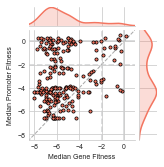

In [34]:
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "Arial"

g = sns.JointGrid(x='Median Gene Fit', y='Median Promoter Fit', data=df_GenePromoterVals_t0,
                  height=65/25.4, ratio=5)

g = g.set_axis_labels('Median Gene Fitness', 'Median Promoter Fitness', fontsize=7)
g = g.plot_joint(sns.scatterplot, color='#F37560', edgecolor='k', s=10)

plt.axvline(x = 0, color = '#D1D2D4', linestyle = '-', linewidth = 1.5, zorder = 0)
plt.axhline(y = 0, color = '#D1D2D4', linestyle = '-', linewidth = 1.5, zorder = 0)
plt.axvline(x = -2, linestyle = '--', linewidth = 1.5, color = '#D1D2D4', zorder = 0)
plt.axhline(y = -2, linestyle = '--', linewidth = 1.5, color = '#D1D2D4', zorder = 0)
x = np.arange(-12,3,1)
y = np.arange(-12,3,1)
plt.plot(x,y, linestyle = '--', color = 'darkgray', linewidth = 1, zorder = 0)

g = g.plot_marginals(sns.kdeplot, color= '#F37560', shade=True)
g.ax_marg_x.set_xlim(-8.5,1)
g.ax_marg_y.set_ylim(-8.5,1)
g.ax_marg_x.tick_params(length=0)
g.ax_marg_y.tick_params(length=0)
g.ax_joint.tick_params(length=0, labelsize=7)

plt.savefig('Section 5v2/Fig_5_b-GeneVSPromoterFit_square_sameaxis_kde.pdf', type = 'pdf')
plt.savefig('Section 5v2/Fig_5_b-GeneVSPromoterFit_square_sameaxis_kde.eps', type = 'eps')

### Data Export

In [35]:
df_Fig5b = df_GenePromoterVals_t0[['Median Gene Fit', 'Median Promoter Fit']].reset_index().rename(columns={'index':'Gene'})
df_Fig5b.to_excel('Section 5v2/Table_Fig-5b.xlsx')
df_Fig5b

,Gene,Median Gene Fit,Median Promoter Fit
0,dxr,-4.813824,NaN
1,ffh,-7.053188,-4.224931
2,fabG,-5.606240,-2.202637
3,mrdB,-4.102012,-4.793273
4,ftsQ,-7.524573,-4.262004
...,...,...,...
300,fabD,-6.141297,-2.202637
301,asd,0.167735,NaN
302,dapE,-2.092506,0.018420
303,era,-4.850030,-4.032500


## Figure 5c (Long-range readthrough)

### Annotation info

In [36]:
3375837-3377815, 3376245-3378223, 3376892-3378870

(-1978, -1978, -1978)

### Visualization

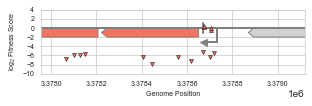

In [37]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene1 = 'rpsI'
gene2 = 'rplM'
gene3 = 'zapE'

list_genes = [gene1, gene2, gene3]

annotation_offset = 1978

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

colors = ['#F37560', '#F37560', '#D1D2D4']

leg_patches = []
i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    leg_patches.append(patches.Patch(color = colors[i], label = gene))
    plt.ylim([-10,4])
    i+=1
plt.legend(handles = leg_patches, loc = 'lower left')
    
plt.xlim([dict_genes_coords[gene1]['(5) Gene_pos_right'].values - 250,
         dict_genes_coords[gene3]['(4) Gene_pos_left'].values + 250])


###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
        DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
        Fitness = df.loc[sgRNA]['LB_ae_avgLR_nmed']
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
            
    i += 1


###Plot promoter graphics
df_promoter = get_promoter_info(gene2)

for promoter in df_promoter['(2) Promoter Name'].unique():
    df = df_promoter[df_promoter['(2) Promoter Name'] == promoter]
    plot_promoter_patch(df, ax, 7)
    ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 9/14, ymax = 11/14, color = 'gray', linewidth = 2)

###Plot promoter sgRNAs
for sgRNA in df_promoter.index:
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_promoter.loc[sgRNA]['LB_ae_avgLR_nmed']
    sgRNAProm_mapping = df_promoter.loc[sgRNA]['mapping orientation']
    if sgRNAProm_mapping == 'for map':
        plt.plot([sgRNA_pos+10], [Fitness], '^', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
    else:
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')


df_promoter = get_promoter_info(gene1)

for promoter in df_promoter['(2) Promoter Name'].unique():
    df = df_promoter[df_promoter['(2) Promoter Name'] == promoter]
    plot_promoter_patch(df, ax, 7)
    ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 9/14, ymax = 11/14, color = 'gray', linewidth = 2)

###Plot promoter sgRNAs
for sgRNA in df_promoter.index:
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_promoter.loc[sgRNA]['LB_ae_avgLR_nmed']
    sgRNAProm_mapping = df_promoter.loc[sgRNA]['mapping orientation']
    if sgRNAProm_mapping == 'for map':
        plt.plot([sgRNA_pos+10], [Fitness], '^', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
    else:
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
        
        

plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_legend().remove()
plt.ylim([-10,4])
ax.set_yticks(np.arange(-10,4+1,2));

plt.savefig('Section 5v2/Fig_5_c-Readthrough_Long_rplM-rpsI_AltColor.pdf', type = 'pdf')

### Data Export

In [38]:
genes_to_viz = ['rpsI', 'rplM', 'zapE']
df_promoter_info = get_promoter_info('rplM').reset_index()
df_promoter_info['category'] = 'Promoter'
df_promoter_info = df_promoter_info[['seq', 'LB_ae_avgLR_nmed', 'category', '(2) Promoter Name', '(3) DNA strand where promoter is loc']]
df_gene_info = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'].isin(genes_to_viz)].reset_index(drop=True)
df_gene_info = df_gene_info[['seq', 'LB_ae_avgLR_nmed', 'category', 'gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)']]
df_Fig5c = pd.concat([df_promoter_info, df_gene_info], axis=0).reset_index(drop=True)
df_Fig5c.to_excel('Section 5v2/Table_Fig-5c.xlsx')
df_Fig5c

,seq,LB_ae_avgLR_nmed,category,(2) Promoter Name,(3) DNA strand where promoter is loc,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
0,cccaataaatagttacacgt,-5.353151,Promoter,rplMp,reverse,NaN,NaN,NaN
1,ccaaacgtcttcaattgttg,-6.304493,Promoter,rplMp,reverse,NaN,NaN,NaN
2,ctcaacaattgaagacgttt,-0.547324,Promoter,rplMp,reverse,NaN,NaN,NaN
3,ccaacgtgtaactatttatt,0.233841,Promoter,rplMp,reverse,NaN,NaN,NaN
4,accaacgtgtaactatttat,0.406644,Promoter,rplMp,reverse,NaN,NaN,NaN
5,cctcaacaattgaagacgtt,-0.121394,Promoter,rplMp,reverse,NaN,NaN,NaN
6,gaggttcacacgacaaagtc,-5.542727,Promoter,rplMp,reverse,NaN,NaN,NaN
7,cggctgacgaactaccatgc,-6.835260,All_Genes,NaN,NaN,rpsI,b3230,1.0
8,agtactgttccagagaacgt,-5.912861,All_Genes,NaN,NaN,rpsI,b3230,1.0
9,attacgattttaccgttgcc,-5.902124,All_Genes,NaN,NaN,rpsI,b3230,1.0


## Figure 5d

### Process

In [39]:
df_compact = df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB_ForPaper_CatSep.copy()
df_compact_t0_filt = df_compact[df_compact['ET165_LB_ae_t0'] >= 5]

### Visualize

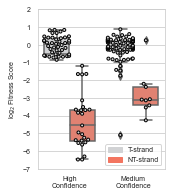

In [60]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"


df_plot = df_compact_t0_filt[(df_compact_t0_filt['readthrough'] == 'high') | (df_compact_t0_filt['readthrough'] == 'medium')]


plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)


ax = sns.boxplot(x = 'readthrough', y = 'LB_ae_avgLR_nmed', data = df_plot, hue = 'mapping orientation',
           order = ['high', 'medium'], palette = ['#D1D2D4', '#F37560'])
ax = sns.swarmplot(x = 'readthrough', y = 'LB_ae_avgLR_nmed', data = df_plot, hue = 'mapping orientation',
           order = ['high', 'medium'], palette = ['lightgray', 'lightgray'], dodge=True, s = 3, edgecolor = 'black', linewidth = 1)

ax.set_xticklabels(['High\nConfidence', 'Medium\nConfidence'], fontsize = 7)

plt.xlabel('')
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
gene_patch = patches.Patch(color = '#F37560', label = 'gene')
promoter_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
ConfHigh_patch = patches.Patch(color = '#F37560', label = 'gene')
CongMed_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
plt.legend([promoter_patch, gene_patch], ['T-strand', 'NT-strand'], fontsize = 7, loc = 'lower right', frameon = True)
plt.ylim([-7,2])


plt.savefig('Section 5v2/Fig_5_d-BoxplotReadthrough_AltColor.pdf', type = 'pdf')

### Stats

In [41]:
Conf_Lvl = 'high'
df_readthrough_High = df_compact_t0_filt[df_compact_t0_filt['readthrough'] == Conf_Lvl]

x = df_readthrough_High[df_readthrough_High['mapping orientation'] == 'for map']['LB_ae_avgLR_nmed'].values
y = df_readthrough_High[df_readthrough_High['mapping orientation'] == 'rev map']['LB_ae_avgLR_nmed'].values
statistics, pvalue = mannwhitneyu(x, y)

mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)

statistics, pvalue, cohens_d

(0.0, 4.225095108023322e-12, 4.2659376174133925)

In [42]:
Conf_Lvl = 'medium'
df_readthrough_High = df_compact_t0_filt[df_compact_t0_filt['readthrough'] == Conf_Lvl]

x = df_readthrough_High[df_readthrough_High['mapping orientation'] == 'for map']['LB_ae_avgLR_nmed'].values
y = df_readthrough_High[df_readthrough_High['mapping orientation'] == 'rev map']['LB_ae_avgLR_nmed'].values
statistics, pvalue = mannwhitneyu(x, y)

mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)

statistics, pvalue, cohens_d

(66.0, 3.902890612154493e-05, 3.203351735036626)

In [43]:
Conf_Lvl = 'low'
df_readthrough_High = df_compact_t0_filt[df_compact_t0_filt['readthrough'] == Conf_Lvl]

x = df_readthrough_High[df_readthrough_High['mapping orientation'] == 'for map']['LB_ae_avgLR_nmed'].values
y = df_readthrough_High[df_readthrough_High['mapping orientation'] == 'rev map']['LB_ae_avgLR_nmed'].values
statistics, pvalue = mannwhitneyu(x, y)

mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)

statistics, pvalue, cohens_d

(603.0, 0.004492140144135299, 0.6258596257170143)

### Data Export

In [44]:
df_Fig5d = df_compact_t0_filt[(df_compact_t0_filt['readthrough'] == 'high') | (df_compact_t0_filt['readthrough'] == 'medium')]
sel_cols = ['sgRNA seq', 'mapping orientation', '(2) Promoter Name', 'LB_ae_avgLR_nmed', 'readthrough']
df_Fig5d = df_Fig5d[sel_cols].reset_index(drop=True)
df_Fig5d.to_excel('Section 5v2/Table_Fig-5d.xlsx')
df_Fig5d

,sgRNA seq,mapping orientation,(2) Promoter Name,LB_ae_avgLR_nmed,readthrough
0,agggcggaccggtatccgag,for map,bamAp,0.603304,medium
1,gggcggaccggtatccgagc,for map,bamAp,0.233616,medium
2,ccttgcgatcgaaaagatca,for map,bamAp,-0.816400,medium
3,cttgcgatcgaaaagatcaa,for map,bamAp,-1.194210,medium
4,cgaaaagatcaagggcggac,for map,bamAp,0.372010,medium
...,...,...,...,...,...
149,caataccggactggcacgct,for map,yjjBp,0.256470,medium
150,aggccacatcaataccggac,for map,yjjBp,0.185670,medium
151,tcaataccggactggcacgc,for map,yjjBp,-0.195441,medium
152,tttaaaggccacatcaatac,for map,yjjBp,0.225821,medium


## Figure 5e

### Top Panel: Polarity

#### Annotation info

In [45]:
2906051-2908029, 2907916-2909894

(-1978, -1978)

#### Visualization

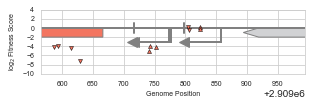

In [46]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene1 = 'pyrG'
gene2 = 'mazG'


list_genes = [gene1, gene2]

annotation_offset = 1978

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

colors = ['#F37560', '#D1D2D4']

leg_patches = []
i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    leg_patches.append(patches.Patch(color = colors[i], label = gene))
    plt.ylim([-10,4])
    i+=1
plt.legend(handles = leg_patches, loc = 'lower left')
    
plt.xlim([dict_genes_coords[gene1]['(5) Gene_pos_right'].values - 100,
         dict_genes_coords[gene2]['(4) Gene_pos_left'].values + 100])


###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
        DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
        Fitness = df.loc[sgRNA]['LB_ae_avgLR_nmed']
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
            
    i += 1

###Plot promoter graphics
df_promoter = get_promoter_info_drop(gene1, ['pyrGp'])

for promoter in df_promoter['(2) Promoter Name'].unique():
    df = df_promoter[df_promoter['(2) Promoter Name'] == promoter]
    plot_promoter_patch(df, ax, 10)
    ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 9/14, ymax = 11/14, color = 'gray', linewidth = 2)
    
df = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains('pyrGp'))].reset_index()
plot_promoter_patch(df, ax, 10)

dict_promoter_offset = {'pyrGp1': 1978, 'pyrGp2': 1978}    
    
###Plot promoter sgRNAs
for sgRNA in df_promoter.index:
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_promoter.loc[sgRNA]['LB_ae_avgLR_nmed']
    sgRNAProm_mapping = df_promoter.loc[sgRNA]['mapping orientation']
    if sgRNAProm_mapping == 'for map':
        plt.plot([sgRNA_pos+10], [Fitness], '^', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
    else:
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')


plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_legend().remove()
plt.ylim([-10,4])
ax.set_yticks(np.arange(-10,4+1,2));

plt.savefig('Section 5v2/Fig_5_e-TandemPromoter_Polarity_pyrG-mazG_AltColor.pdf', type = 'pdf')

#### Data Table

In [47]:
genes_to_viz = ['pyrG', 'mazG']
df_promoter_info = df_map_ann_PromInTUSet_dropnapromotername[(df_map_ann_PromInTUSet_dropnapromotername['(2) Promoter Name'].str.contains('pyrGp'))].rename(columns={'sgRNA seq':'seq'})
df_promoter_info['category'] = 'Promoter'
df_promoter_info = df_promoter_info[['seq', 'LB_ae_avgLR_nmed', 'category', '(2) Promoter Name', '(3) DNA strand where promoter is loc']]
df_gene_info = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'].isin(genes_to_viz)].reset_index(drop=True)
df_gene_info = df_gene_info[['seq', 'LB_ae_avgLR_nmed', 'category', 'gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)']]
df_Fig5e_top = pd.concat([df_promoter_info, df_gene_info], axis=0).reset_index(drop=True)
df_Fig5e_top

,seq,LB_ae_avgLR_nmed,category,(2) Promoter Name,(3) DNA strand where promoter is loc,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
0,ataatgaaagtttgtggcac,-4.084060,Promoter,pyrGp,reverse,NaN,NaN,NaN
1,ttgtggcacaggtcatgttc,-4.934759,Promoter,pyrGp,reverse,NaN,NaN,NaN
2,ggtatactgctttcccgtct,-0.761606,Promoter,pyrGp,reverse,NaN,NaN,NaN
3,tttgtggcacaggtcatgtt,-3.984009,Promoter,pyrGp,reverse,NaN,NaN,NaN
4,gtcaaaaacatttaccccaa,0.174936,Promoter,pyrGp1,reverse,NaN,NaN,NaN
5,gtgagaaaatagcccctttg,0.075148,Promoter,pyrGp1,reverse,NaN,NaN,NaN
6,agtgagaaaatagccccttt,-0.423249,Promoter,pyrGp1,reverse,NaN,NaN,NaN
7,tcaaaaacatttaccccaaa,-0.249464,Promoter,pyrGp1,reverse,NaN,NaN,NaN
8,gagtgagaaaatagcccctt,0.285732,Promoter,pyrGp1,reverse,NaN,NaN,NaN
9,ataatgaaagtttgtggcac,-4.084060,Promoter,pyrGp2,reverse,NaN,NaN,NaN


### Bottom Panel: All

#### Annotation info

In [48]:
193521-193521, 194903-194903

(0, 0)

#### Visualization

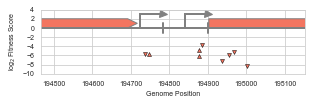

In [49]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (120/25.4, 30/25.4))
plt.rcParams["font.family"] = "Arial"
ax = fig.add_subplot(1,1,1)
ax.axhline(y = 0, color = 'gray', lw = 2)

gene1 = 'dxr'
gene2 = 'ispU'

list_genes = [gene1, gene2]

annotation_offset = 0

###Draw gene graphics
dict_genes_coords = {gene:GeneSet[GeneSet['(2) Gene name'] == gene] for gene in list_genes}

colors = ['#F37560', '#F37560']

leg_patches = []
i = 0
for gene in list_genes:
    df = dict_genes_coords[gene]
    plot_gene_patch_2(df, ax, colors[i])
    leg_patches.append(patches.Patch(color = colors[i], label = gene))
    plt.ylim([-10,4])
    i+=1
plt.legend(handles = leg_patches, loc = 'lower left')
    
plt.xlim([dict_genes_coords[gene1]['(5) Gene_pos_right'].values - 250,
         dict_genes_coords[gene2]['(4) Gene_pos_left'].values + 250])


###Plot gene sgRNAs
dict_genes_data = {gene:df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene] for gene in list_genes}

i = 0
for gene in list_genes:
    df = dict_genes_data[gene]
    for sgRNA in df.index:
        sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
        DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
        Fitness = df.loc[sgRNA]['LB_ae_avgLR_nmed']
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color = colors[i], ms = 4, mew=0.5, mec='k')
            
    i += 1


###Plot promoter graphics
df_promoter = get_promoter_info(gene2)

for promoter in df_promoter['(2) Promoter Name'].unique():
    df = df_promoter[df_promoter['(2) Promoter Name'] == promoter]
    plot_promoter_patch(df, ax, 7)
    ax.axvline(x = df['(4) Genome map position of TSS (+1)'].unique(), ymin = 9/14, ymax = 11/14, color = 'gray', linewidth = 2)

###Plot promoter sgRNAs
for sgRNA in df_promoter.index:
    sgRNA_pos = df_sgRNA_info_update_3.loc[sgRNA]['pos'] + annotation_offset
    DNAstrandsgRNA = df_sgRNA_info_update_3.loc[sgRNA]['strand']
    Fitness = df_promoter.loc[sgRNA]['LB_ae_avgLR_nmed']
    sgRNAProm_mapping = df_promoter.loc[sgRNA]['mapping orientation']
    if sgRNAProm_mapping == 'for map':
        plt.plot([sgRNA_pos+10], [Fitness], '^', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')
    else:
        plt.plot([sgRNA_pos+10], [Fitness], 'v', label = 'sgRNA', color =  '#F37560', ms = 4, mew=0.5, mec='k')

plt.xlabel('Genome Position', fontsize = 7)
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
ax.get_legend().remove()
plt.ylim([-10,4])
ax.set_yticks(np.arange(-10,4+1,2));

plt.savefig('Section 5v2/Fig_5_e-TandemPromoter_All_dxr-ispU_AltColor.pdf', type = 'pdf')

#### Data Table

In [50]:
genes_to_viz = ['dxr', 'ispU']
df_promoter_info = get_promoter_info('ispU').reset_index()
df_promoter_info['category'] = 'Promoter'
df_promoter_info = df_promoter_info[['seq', 'LB_ae_avgLR_nmed', 'category', '(2) Promoter Name', '(3) DNA strand where promoter is loc']]
df_gene_info = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'].isin(genes_to_viz)].reset_index(drop=True)
df_gene_info = df_gene_info[['seq', 'LB_ae_avgLR_nmed', 'category', 'gene_name_F2', 'bnumber_F2', 'Class(1:essential 2:noessential 3:unknown)']]
df_Fig5e_bot = pd.concat([df_promoter_info, df_gene_info], axis=0)
df_Fig5e_bot

,seq,LB_ae_avgLR_nmed,category,(2) Promoter Name,(3) DNA strand where promoter is loc,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
0,gtcgcgctatttgttagcgt,-5.594034,Promoter,ispUp1,forward,NaN,NaN,NaN
1,atagcgcgactctctgtagc,-5.735893,Promoter,ispUp1,forward,NaN,NaN,NaN
2,gagtaccgtaaaccctgtca,-6.084611,Promoter,ispUp2,forward,NaN,NaN,NaN
3,ttattccctgacagggttta,-3.801539,Promoter,ispUp2,forward,NaN,NaN,NaN
4,tgagtaccgtaaaccctgtc,-4.842649,Promoter,ispUp2,forward,NaN,NaN,NaN
0,cgagccggtcgagcccagaa,-4.726955,All_Genes,NaN,NaN,dxr,b0173,1.0
1,cgtgctgcaaccaatcgagc,-6.078946,All_Genes,NaN,NaN,dxr,b0173,1.0
2,gcaactacgcggaagtgttc,-4.900692,All_Genes,NaN,NaN,dxr,b0173,1.0
3,cgcaactacgcggaagtgtt,-4.240936,All_Genes,NaN,NaN,dxr,b0173,1.0
4,gctggcaatttttcgctaag,-7.152475,All_Genes,NaN,NaN,ispU,b0174,1.0


### Data Export

In [51]:
df_Fig5e = pd.concat([df_Fig5e_top, df_Fig5e_bot], axis=0).reset_index(drop=True)
df_Fig5e.to_excel('Section 5v2/Table_Fig-5e.xlsx')
df_Fig5e

,seq,LB_ae_avgLR_nmed,category,(2) Promoter Name,(3) DNA strand where promoter is loc,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
0,ataatgaaagtttgtggcac,-4.084060,Promoter,pyrGp,reverse,NaN,NaN,NaN
1,ttgtggcacaggtcatgttc,-4.934759,Promoter,pyrGp,reverse,NaN,NaN,NaN
2,ggtatactgctttcccgtct,-0.761606,Promoter,pyrGp,reverse,NaN,NaN,NaN
3,tttgtggcacaggtcatgtt,-3.984009,Promoter,pyrGp,reverse,NaN,NaN,NaN
4,gtcaaaaacatttaccccaa,0.174936,Promoter,pyrGp1,reverse,NaN,NaN,NaN
5,gtgagaaaatagcccctttg,0.075148,Promoter,pyrGp1,reverse,NaN,NaN,NaN
6,agtgagaaaatagccccttt,-0.423249,Promoter,pyrGp1,reverse,NaN,NaN,NaN
7,tcaaaaacatttaccccaaa,-0.249464,Promoter,pyrGp1,reverse,NaN,NaN,NaN
8,gagtgagaaaatagcccctt,0.285732,Promoter,pyrGp1,reverse,NaN,NaN,NaN
9,ataatgaaagtttgtggcac,-4.084060,Promoter,pyrGp2,reverse,NaN,NaN,NaN


## Supp Info

### Process

In [52]:
Egenes_Fit_LEq_m2 = ['acpS','asd','bamD','birA','can','cca','degS','efp','erpA','fldA','folB','folK','glmS',
                     'grpE','hemG','hemL','lexA','ligA','nadD','nadE','priA','ribB','tilS','topA','ubiA','yabQ',
                     'yceQ','yqgD','yqgF']

In [53]:
dict_gene_promoter_sgpairsfitness = {}

for gene in Egenes_Fit_LEq_m2:
    gene_sgRNA_fitness = df_LRs_GEq_2e6_nmed_selcols[df_LRs_GEq_2e6_nmed_selcols['gene_name_F2'] == gene]['LB_ae_avgLR_nmed'].values
    promoter_sgRNA_fitness = []
    for ind in df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB.index:
        genes_in_TU = df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['(4) Name of the gene(s) in TU'].loc[ind]
        if gene in genes_in_TU:
            promoter_sgRNA_fitness.append(df_map_ann_PromInTUSet_dropnapromotername_EssTus_LB['LB_ae_avgLR_nmed'][ind])
    dict_gene_promoter_sgpairsfitness[gene] = [gene_sgRNA_fitness, promoter_sgRNA_fitness]

### Visualization

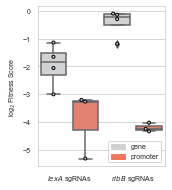

In [59]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (58/25.4, 74.5/25.4))
ax = fig.add_subplot(1,1,1)
plt.rcParams["font.family"] = "Arial"

gene1 = 'lexA'
gene2 = 'ribB'

data = [dict_gene_promoter_sgpairsfitness[gene1][0], np.array(dict_gene_promoter_sgpairsfitness[gene1][1]),
        dict_gene_promoter_sgpairsfitness[gene2][0], np.array(dict_gene_promoter_sgpairsfitness[gene2][1])]

sns.boxplot(data = data, palette = ['#D1D2D4', '#F37560'])
sns.swarmplot(data = data, palette = ['lightgray', 'lightgray'], s = 3, edgecolor = 'black', linewidth = 1)
#ax.set(xticklabels = ['gene', 'promoter', 'gene', 'promoter'])
#ax.set([0,1], xticklabels = ['lexA sgRNAs', 'ribB sgRNAs'])
plt.xticks([0.5,2.5], ['$lexA$ sgRNAs', '$ribB$ sgRNAs'])
plt.ylabel('log$_2$ Fitness Score', fontsize = 7)
plt.tick_params('both', labelsize = 7)
gene_patch = patches.Patch(color = '#F37560', label = 'gene')
promoter_patch = patches.Patch(color = '#D1D2D4', label = 'promoter')
plt.legend([promoter_patch, gene_patch], ['gene', 'promoter'], fontsize = 7, loc = 'lower right', frameon = True)

plt.savefig('Section 5v2/SuppFig_GeneVSPromotersgRNAs_alt_AltColor.pdf', type = 'pdf')

### Stats

In [55]:
gene = 'ribB'

x = dict_gene_promoter_sgpairsfitness[gene][0]
y = dict_gene_promoter_sgpairsfitness[gene][1]
statistics, pvalue = mannwhitneyu(x, y)

mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)

statistics, pvalue, cohens_d

(0.0, 0.02591496360895484, 10.727367075858902)

In [56]:
gene = 'lexA'

x = dict_gene_promoter_sgpairsfitness[gene][0]
y = dict_gene_promoter_sgpairsfitness[gene][1]
statistics, pvalue = mannwhitneyu(x, y)

mean_x = np.mean(x)
mean_y = np.mean(y)
pooled_var = calc_pooled_var(len(x), np.var(x), len(y), np.var(y))
cohens_d = calc_cohens_d(mean_x, mean_y, pooled_var)

statistics, pvalue, cohens_d

(0.0, 0.02591496360895484, 2.4074445416186774)

### Data Export

In [57]:
gene1, gene2 = 'lexA', 'ribB'

data = [dict_gene_promoter_sgpairsfitness[gene1][0], np.array(dict_gene_promoter_sgpairsfitness[gene1][1]),
        dict_gene_promoter_sgpairsfitness[gene2][0], np.array(dict_gene_promoter_sgpairsfitness[gene2][1])]

sgRNA_feature = [['gene' for i in np.arange(0,len(dict_gene_promoter_sgpairsfitness[gene1][0]))],
                 ['promoter' for i in np.arange(0,len(np.array(dict_gene_promoter_sgpairsfitness[gene1][1]) ))],
                 ['gene' for i in np.arange(0,len(dict_gene_promoter_sgpairsfitness[gene2][0]))],
                 ['promoter' for i in np.arange(0,len(np.array(dict_gene_promoter_sgpairsfitness[gene2][1]) ))]]
gene_annot = [[gene1 for i in np.arange(0,len(dict_gene_promoter_sgpairsfitness[gene1][0]))],
                 [gene1 for i in np.arange(0,len(np.array(dict_gene_promoter_sgpairsfitness[gene1][1]) ))],
                 [gene2 for i in np.arange(0,len(dict_gene_promoter_sgpairsfitness[gene2][0]))],
                 [gene2 for i in np.arange(0,len(np.array(dict_gene_promoter_sgpairsfitness[gene2][1]) ))]]

data = [item for sublist in data for item in sublist]
sgRNA_feature = [item for sublist in sgRNA_feature for item in sublist]
gene_annot = [item for sublist in gene_annot for item in sublist]


df_SuppFig_11 = pd.DataFrame({'gene':gene_annot, 'LB_ae_avgLR_nmed':data, 'category':sgRNA_feature})
df_SuppFig_11.to_excel('Section 5v2/Table_SuppFig-11.xlsx')
df_SuppFig_11

,gene,LB_ae_avgLR_nmed,category
0,lexA,-3.009798,gene
1,lexA,-1.142319,gene
2,lexA,-1.657062,gene
3,lexA,-2.062657,gene
4,lexA,-5.322779,promoter
5,lexA,-3.208152,promoter
6,lexA,-3.271062,promoter
7,ribB,-0.297559,gene
8,ribB,-0.099797,gene
9,ribB,-1.185253,gene
